# Notes on Chapter 4 of *Hands-On Machine Learning with Scikit-Learn, Keras, & TensorFlow* by Aurélien Géron

## Linear regression

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
np.random.seed(1811)

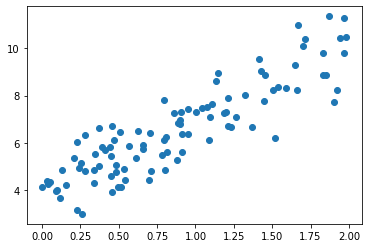

In [3]:
X = 2*np.random.rand(100,1)
X_aug = np.c_[X, np.ones(len(X))]

theta = np.array([3,4])
y = X_aug.dot(theta) + np.random.normal(size=(X.shape[0]))
plt.scatter(X[:,0], y)

Solve using the normal equation

In [4]:
theta_hat = np.linalg.inv(X_aug.T.dot(X_aug)).dot(X_aug.T).dot(y)
theta_hat

array([3.05371062, 3.88601208])

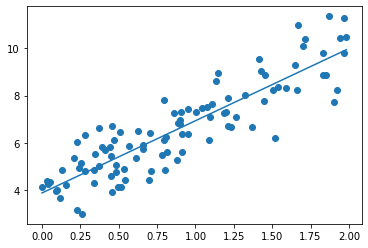

In [5]:
plt.scatter(X[:,0], y)
plt.plot([min(X), max(X)], theta_hat.dot(np.c_[[min(X), 1], [max(X), 1]]))

Solve using sklearn...

In [6]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.coef_, lin_reg.intercept_

(array([3.05371062]), 3.8860120754449277)

...which uses numpy's least squares...

In [7]:
svd, residuals, rank, s = np.linalg.lstsq(X_aug, y, rcond=1e-6)
svd

array([3.05371062, 3.88601208])

...which uses the Moore--Penrose inverse.

In [8]:
np.linalg.pinv(X_aug).dot(y)

array([3.05371062, 3.88601208])

Batch gradient descent:

In [9]:
eta = 0.005 # learning rate
max_iter = 1000

theta_hat = np.random.normal(size=X_aug.shape[1])
for i in range(max_iter):
    grad = 2/X_aug.shape[1] * X_aug.T.dot(X_aug.dot(theta_hat) - y)
    theta_hat = theta_hat - eta * grad

theta_hat

array([3.05371062, 3.88601208])

Stochastic gradient descent:

In [10]:
max_epochs = 1000
eta0 = 0.1
t0 = 100

def learning_schedule(t):
    return eta0 * t0 / (t + t0)

theta_hat = np.random.normal(size=X_aug.shape[1])

for epoch in range(max_epochs):
    for i in range(X_aug.shape[0]):
        j = np.random.randint(X_aug.shape[0])
        grad = 2 * X_aug[j].dot(X_aug[j].dot(theta_hat) - y[j])
        eta = learning_schedule(epoch * X_aug.shape[0] + i)
        theta_hat = theta_hat - eta * grad
        
theta_hat

array([3.03768816, 3.88182368])

In [11]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd.fit(X, y)
sgd.coef_, sgd.intercept_

(array([3.05138139]), array([3.85937062]))

Minibatch gradient descent:

In [12]:
max_epochs = 1000
batch_size = 10
eta0 = 0.1
t0 = 50

def learning_schedule(t):
    return eta0 * t0 / (t + t0)

theta_hat = np.random.normal(size=X_aug.shape[1])

for epoch in range(max_epochs):
    for batch in range(int(X_aug.shape[0]/batch_size)):
        i_batch = np.random.choice(X_aug.shape[0], batch_size, replace=False)
        X_batch = X_aug[i_batch]
        y_batch = y[i_batch]
        grad = 2/X_batch.shape[1] * X_batch.T.dot(X_batch.dot(theta_hat) - y_batch)
        eta = learning_schedule(epoch * X_aug.shape[0] + batch * batch_size)
        theta_hat = theta_hat - eta * grad
        
theta_hat

array([3.05827279, 3.87738192])

Polynomial regression

Start by generating a non-linear dataset:

In [13]:
m = 100
X = 6 * np.random.rand(m,1) - 3
y = (0.5 * X**2 + X + 2 + 0.5 * np.random.randn(m,1))[:,0]

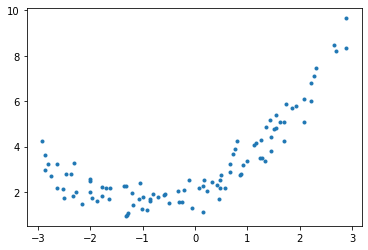

In [14]:
plt.plot(X, y, '.')

In [15]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [16]:
X[:3], X_poly[:3]

(array([[ 0.670181  ],
        [ 1.26482011],
        [-1.18910569]]),
 array([[ 0.670181  ,  0.44914257],
        [ 1.26482011,  1.5997699 ],
        [-1.18910569,  1.41397233]]))

In [17]:
lm = LinearRegression()
lm.fit(X_poly, y)
lm.intercept_, lm.coef_

(2.039816889317422, array([0.97728201, 0.4907733 ]))

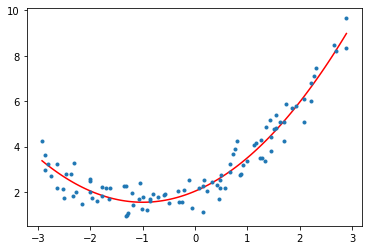

In [18]:
x_linear = np.linspace(min(X), max(X), 100)

plt.plot(x_linear, lm.predict(poly_features.transform(x_linear)), 'r')
plt.plot(X, y, '.')

Learning curves

In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(m, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors = []
    val_errors = []
    for N in range(1, X_train.shape[0]):
        m.fit(X_train[:N], y_train[:N])
        y_hat_train = m.predict(X_train[:N])
        y_hat_val = m.predict(X_val)
        train_errors.append(mean_squared_error(y_hat_train, y_train[:N]))
        val_errors.append(mean_squared_error(y_hat_val, y_val))
    plt.plot(np.sqrt(train_errors), "r-+", label="train")
    plt.plot(np.sqrt(val_errors), "b-", label="val")
    plt.legend()

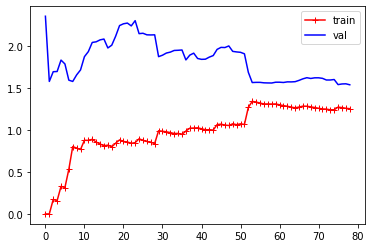

In [20]:
plot_learning_curves(LinearRegression(), X, y)

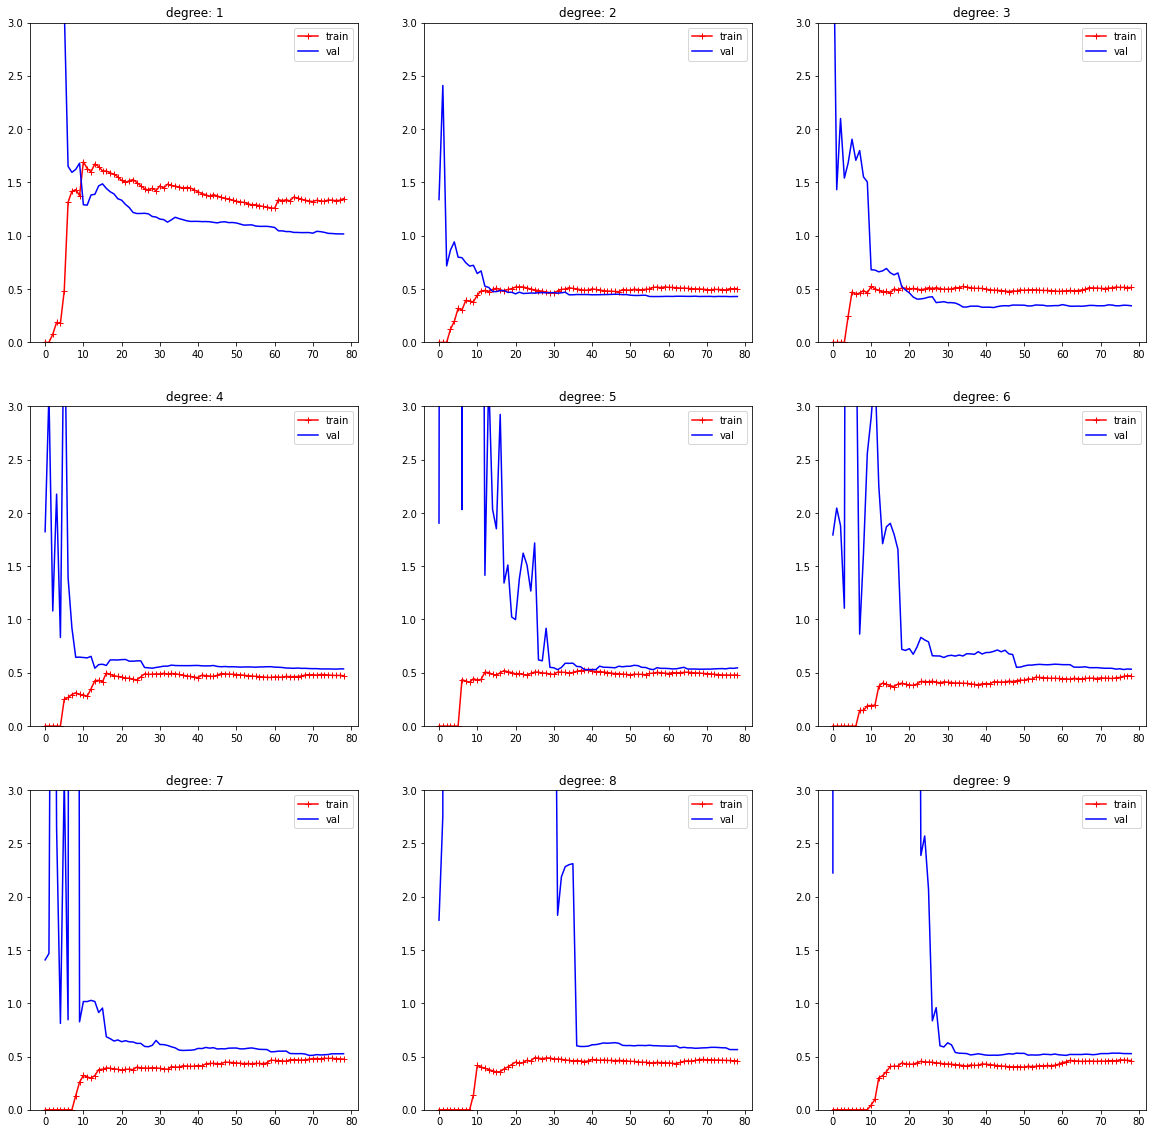

In [21]:
from sklearn.pipeline import Pipeline

numplots = 9
numcols = 3
plt.subplots(figsize=(20,20))
for i in range(numplots):
    ax = plt.subplot(numplots/numcols, numcols, i+1)
    plot_learning_curves(Pipeline([
        ("poly", PolynomialFeatures(degree=i+1, include_bias=False)),
        ("lr", LinearRegression())
    ]), X, y)
    plt.ylim(0, 3)
    plt.title(f'degree: {i+1}')

Ridge regression can be performed via Cholesky decomposition...

In [22]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1, solver="cholesky")
ridge.fit(X, y)
ridge.predict([[1.5]])

array([4.53471283])

...and with stochastic gradient descent:

In [23]:
sgd = SGDRegressor(penalty="l2")
sgd.fit(X, y)
sgd.predict([[1.5]])

array([4.51986443])

Lasso also is available:

In [24]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X, y)
lasso.predict([[1.5]])

array([4.47776175])

...as are elastic nets:

In [25]:
from sklearn.linear_model import ElasticNet
en = ElasticNet(alpha=0.1, l1_ratio=0.5)
en.fit(X, y)
en.predict([[1.5]])

array([4.48457273])

Example implementation of early stopping:

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [27]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

polyscaler = Pipeline([
    ('poly', PolynomialFeatures(degree=90, include_bias=False)),
    ('scaler', StandardScaler())
])
X_train_proc = polyscaler.fit_transform(X_train)
X_val_proc = polyscaler.transform(X_val)

sgd = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None, learning_rate='constant', eta0=0.0005)
min_error = np.infty
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd.fit(X_train_proc, y_train)
    y_hat_val = sgd.predict(X_val_proc)
    val_error = mean_squared_error(y_val, y_hat_val)
    if val_error < min_error:
        min_error = val_error
        best_epoch = epoch
        best_model = clone(sgd)

min_error, val_error

(0.23451262885181862, 0.30472019253228444)

Load the Iris dataset

In [28]:
from sklearn import datasets

iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [29]:
iris['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

Fit a single class logistic regression model on the data.

In [30]:
from sklearn.linear_model import LogisticRegression

X = iris['data'][:, 3:] # petal width
y = (iris['target'] == 2).astype(np.int)
log_reg = LogisticRegression()
log_reg.fit(X,y);

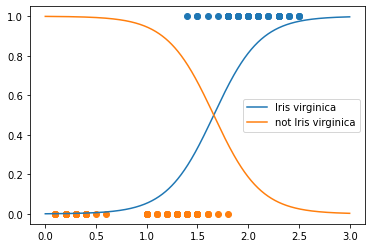

In [31]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:,1], label="Iris virginica")
plt.plot(X_new, y_proba[:,0], label="not Iris virginica")
plt.scatter(X[y == 1], y[y==1])
plt.scatter(X[y == 0], y[y==0])
plt.legend()

Three class example:

In [32]:
X = iris['data'][:, 2:] # petal length and width
y = iris['target']
softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10)
softmax_reg.fit(X,y);
softmax_reg.predict_proba([[5,2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

## Exercises

### 1

Mini-batch gradient descent or stochastic gradient descent.

### 2

All of the algorithms can suffer from this, as it can lead to a poorly conditioned matrix for SVD or the Normal Equation and a very narrow valley for the various gradient descent methods.  Appropriate non-dimensionalization or scaling of the data can fix this.  

### 3

No, there is a single minima which is the global minima.

### 4

Assuming the loss function is convex and that the learning rate is decreased asymptotically towards zero over time, yes.  

### 5

Assuming your loss on the training set is decreasing, overfitting is occuring, which can be addressed using regularization techniques such as adding/increasing an $L_1$ or $L_2$ penalty, early stopping, dropout, etc..

### 6

Usually not, as it is a stochastic algorithm and will have many loss increments and decrements on individual steps.

### 7

Often minibatch gradient descent with a small batch size will reach a reasonable neighborhood of the local minima in the least amount of CPU time.  Batch gradient decent will converge (with the appropriate fixed or variable learning rate) as will stochastic and mini-batch gradient descent if the learning rate asymptotically approaches zero.

### 8

Overfitting is likely occurring, which you may be able to address with better regularization or by adding more data.

### 9

High bias, suggesting the regularization parameter should be decreased.

### 10
#### a
To decrease overfitting when you have many features for the number of samples you have.
#### b 
When you wish to have some degree of feature selection as lasso will reduce coefficients to zero.
#### c
To improve convergence when the number of features is greater than the number of training instances or when some features are strongly corellated. 


### 11

You probably should start with two separate logistic regression functions as the simplest model (e.g. assuming one can neglect the interaction terms), but should try softmax if time allows (as the interaction terms may be very relevant).  

### 12

We'll have fun and use FP16 math in tensorflow, since we're not supposed to use sklearn...

In [33]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from matplotlib import pyplot as plt

First, we need a dataset to work with.  We'll use the sklearn datasets for this for convenience (since it's not part of the batch gradient descent algorithm).

In [34]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [35]:
X = mnist['data']
y = mnist['target']
num_classes = 10
size_train = 60000
dtype = tf.float16

X_train = tf.constant(X[:size_train]/255, dtype=dtype)
X_test = tf.constant(X[size_train:]/255, dtype=dtype)
y_train = y[:size_train]
y_test = y[size_train:]

y_train_onehot = tf.cast(tf.one_hot(y_train, num_classes), dtype=dtype)
y_test_onehot = tf.cast(tf.one_hot(y_test, num_classes), dtype=dtype)

In [46]:
@tf.function()
def apply_softmax(theta, X):
    u = tf.tensordot(X, theta, [[1],[1]])
    v = tf.math.exp(tf.clip_by_value(u, -6, 6))
    return v / tf.reduce_sum(v, axis=1)[:, tf.newaxis]

@tf.function()
def softmax_gradient(theta, X, y):
    y_hat = apply_softmax(theta, X)
    return tf.reduce_mean(
        (y_hat - y)[:, :, tf.newaxis] * X[:, tf.newaxis, :], axis=0)
    
@tf.function()
def loss(theta, X, y):
    y_hat = apply_softmax(theta, X)
    return -tf.math.reduce_mean(y * tf.math.log(y_hat))

eta0=0.6
tau=100
max_iter = 10000

# initialize the weights
theta = tfd.Normal(
    tf.constant(0., dtype=dtype),
    tf.constant(1., dtype=dtype),
    ).sample((num_classes, X_train.shape[1], ))

training_loss = []
validation_loss = []
for i in range(max_iter):
    eta = eta0 / (1 + i/tau)
    theta = theta - eta * softmax_gradient(
        theta, X_train, y_train_onehot)
    training_loss.append(loss(theta, X_train, y_train_onehot))
    validation_loss.append(loss(theta, X_test, y_test_onehot))
    print(f'\r{i}: {training_loss[-1]:.4f} {validation_loss[-1]:.4f}',
         end='')
    if i > 0 and validation_loss[-1] > validation_loss[-2]:
        print(f'\nstopping early at {i+1} steps')
        break


596: 0.0961 0.0911
stopping early at 597 steps


final accuracy: 0.730


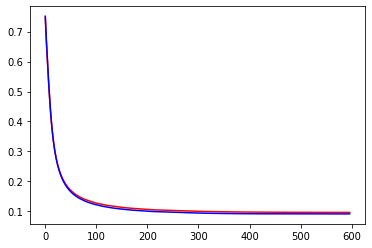

In [47]:
plt.plot(training_loss, 'r')
plt.plot(validation_loss, 'b');

y_hat_test_onehot = apply_softmax(theta, X_test)
y_hat_test = tf.math.argmax(y_hat_test_onehot, axis=1)
accuracy = tf.reduce_mean(tf.cast(y_hat_test == y_test, dtype))
print(f'final accuracy: {accuracy:.3f}')